## Please note that this particular script does not contain much comments for its functions. This was my first attempt to create a GUI in python. An excel formula can easily replace more of the script's functions, except for the addition of the voice reminders.

### This script can be used when perfusions of a group/batch are running concommitantly with experimental trials of other groups/batches which are also going to be perfused.

#### Once the script is run, an OpenFileDialog will open. The user has to select an excel file in which the information of Group and ID are indicated as below.

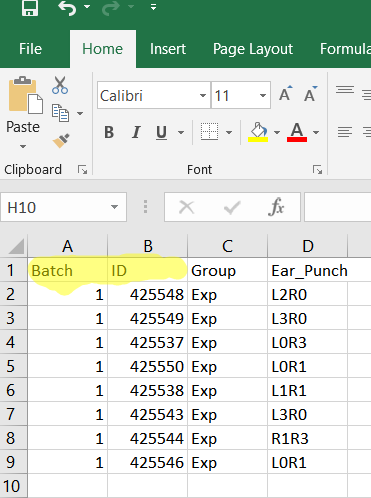

#### The user then has to type the duration of the trials, the waiting time before the initiation of the trial and the perfusion as well as the time that the next group is going to be tested.

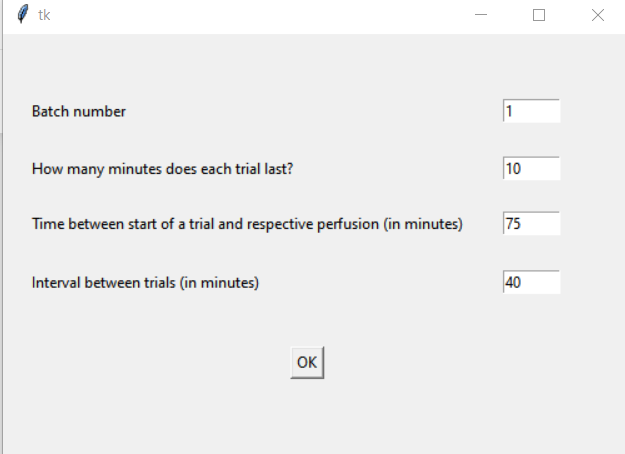

#### After inserting these details, the user checks the boxes of the animals that are going to be perfused (up to 2 at a time) and presses the button 'Ready!'. The startime, remove time, time to run new trial and perfusion time will appear. Every time a perfusion is about to start in 10 minutes, a voice message will remind the user. In addition, two minutes before a group's/batch's trial is supposed to end, a voice message will remind the user. 

###### next_perfuse.wav and remove_mice.wav are the voice commands files. You can make your own recordings, name them according to these names and put them to the same directory with the ipynb file.

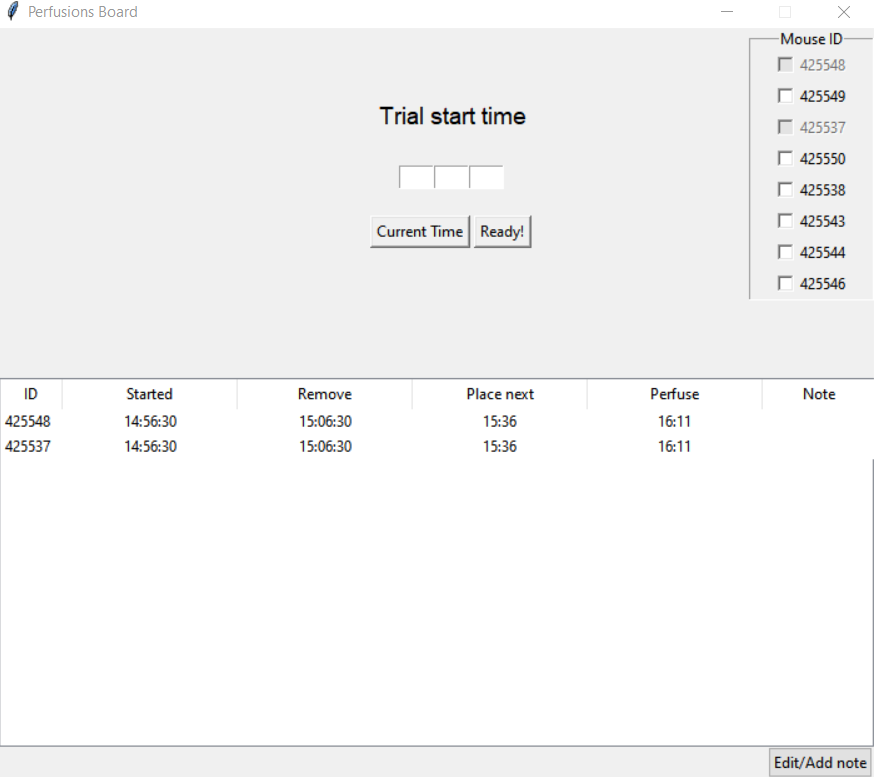

#### You can add notes for each mouse as well as change the ID's in case you made a mistake.

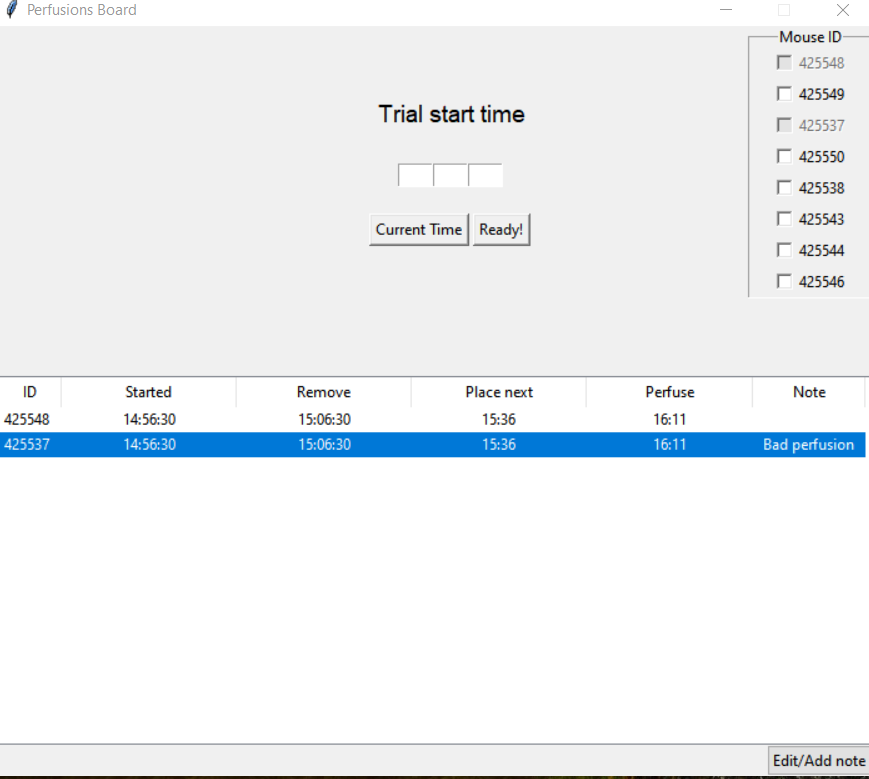

In [11]:
import pandas as pd
import datetime as dt
import numpy as np
import sys
import time
import winsound
import threading
import csv
import tkinter
from tkinter import messagebox
from tkinter import *
from tkinter import filedialog as fd
from tkinter import simpledialog as sd
from tkinter import ttk


In [12]:
def GlobalizeEntries():
    """ Out of already existent variables, makes new ones that are global. These variables are the batch number, the duration
    of the trials, the time that it takes to perfuse after starting the experiment and the time gap between consecutive trials"""

    global batch_num 
    global trial_dur 
    global perf_interv
    global iti
    
    global batch
    batch = batch_num.get()
    global trial 
    trial = trial_dur.get()
    global perfusion_interval
    perfusion_interval = perf_interv.get()
    global intertrial_int
    intertrial_int = iti.get()

In [13]:
def FirstInputs():
    """ Creates widgets to receive the batch number, the duration of the trials, the time that it takes to perfuse after 
    starting the experiment and the time gap between consecutive trial. Creates additional variables so the dataframe with
    all information (like batch number, IDs etc) can be made"""

    global alarms, df, batch_num, trial_dur, perf_interv, iti, proj_det, codes, perf_alarm, remove_alarm, event, edit_event, all_vars, all_cb

    alarms = {'startime':[""], 'rem_time':[""], 'nextime':[""], 'perf_time':[""]}    # have 2to be strings inside to avoid TyperError
    df = pd.DataFrame()

    first_root = Tk()
    first_root.geometry ('500x500')

    first_root.update()
    filename = fd.askopenfilename(initialdir="C:/", title = "select database", filetypes=(('Excel files', '*.xl*',),('All files', '*.*')))

    
    batch_num = Entry(first_root, width =7)
    batch_num.place(x=400,y= 52)
    batch_lab = Label(first_root, text ='Batch number')
    batch_lab.place(x=20, y = 51)

    trial_dur = Entry(first_root, width =7)
    trial_dur.place(x=400,y= 98)
    trial_lab = Label(first_root, text ='How many minutes does each trial last?') 
    trial_lab.place(x=20, y = 97)

    perf_interv = Entry(first_root, width =7)
    perf_interv.place(x=400,y= 142)
    perf_lab = Label(first_root, text ='Time between start of a trial and respective perfusion (in minutes)') 
    perf_lab.place(x=20, y = 141)

    iti = Entry(first_root, width =7)
    iti.place(x=400,y= 189)
    iti_lab = Label(first_root, text ='Interval between trials (in minutes)') 
    iti_lab.place(x=20, y = 188)

    start_but = Button(first_root, text = 'OK' , command = lambda : [GlobalizeEntries(),first_root.destroy()])
    start_but.place(x =230, y = 250)

    first_root.mainloop()


    
    ### Additional Variables created ###
    
    proj_det = pd.read_excel(filename, index_col="Batch")
    codes = [str(int(x)) for x in proj_det.loc[int(batch)]["ID"].tolist()]      # each code converted to string after rounded 
    perf_alarm = 'next_perfuse.wav'                                             # voice message that will play 10 min before perfusion
    remove_alarm = 'remove_mice.wav'
    event = threading.Event()                                                   # helps control whether an alarm will be set or not based on the time input (right or wrong, respectively)
    edit_event = threading.Event()                                              # helps control whether an alarm will be set or not based on the time input (right or wrong, respectively) while editing a row
    all_vars = []                                                               # list with tkinter variables that correspond to the condition of a checkbutton (0=unchecked, 1=checked)      
    all_cb = []                                                                 # list with the checkbuttons so we can disable them if necessary

In [14]:
def AlarmCheck ():
    """ Will be running in parallel as a thread along with the Core(). Every 0.5 seconds, it checks whether there is sth that 
        needs to be done in a few minutes. If so, a voice command will also play and the alarm time will be removed from the dict"""
    while True:   # does it burden the program ?
        time.sleep(0.5)
        curr_time = dt.datetime.now()
        potential_rem_time  =  (curr_time + dt.timedelta(minutes=2)).strftime("%H:%M:%S")    # this is the time in 2 minutes from now
        potential_perf_time = (curr_time + dt.timedelta(minutes=10)).strftime("%H:%M")
        
        if potential_rem_time in alarms['rem_time']:
            winsound.PlaySound(remove_alarm, winsound.SND_FILENAME)
            alarms['rem_time'].remove(potential_rem_time)
        # alarms dont play. Check if time is in different form     
        if potential_perf_time in alarms['perf_time']:
            winsound.PlaySound(perf_alarm, winsound.SND_FILENAME)
            alarms['perf_time'].remove(potential_perf_time)

In [15]:
def CurrTime(ehour,emin,esec):
    """Sets the current time hour/minutes/seconds to each one of the three tkinter entries (ehour,emin,esec) This time will
    only be registered when the Ready button is pressed, that is when SetAlarms() is called.
    
    ehour : tkinter Entry
    emin  : tkinter Entry
    esec  : tkinter Entry
                            """
    
    # not to confuse with time (the import) or TimeT
    Time = dt.datetime.now().strftime("%H:%M:%S")                
    currhour = Time[0:2]
    currtime = Time[3:5]
    currsec  = Time[6:]
    
    # attribute couple of numbers for hour/minutes/seconds to respective entries
    ehour.delete(0,tkinter.END)
    ehour.insert(1,currhour)
    emin.delete(0,tkinter.END)
    emin.insert(1,currtime)
    esec.delete(0,tkinter.END)
    esec.insert(1,currsec)
    

In [16]:
def edit():
    
    global all_cb
    backup_values = []
    
    #  Get selected items to Edit. [:] means that all selected items will be edited. [0] would mean only the first of the selected ones
    # we could retrieve values directly from selected_items but for ease a 'backup_values list will be later created'
    selected_items = tree.selection()[:] 
    n_selected = len(selected_items)
    
    # tree.item(oneitem) yields a directory where all row's values are stored in a "values" key by default.
    ## For instance, tree.item(oneitem)['values'][0] is the id, because the id is the first value out of all
    ### here we create a list that stores all values from the selected rows of the treeview   
    for oneitem in selected_items :
        # Maybe the copy [:] is not needed here
        # this is a list with lists as elements. Every element has all values of the row
        backup_values.append (tree.item(oneitem)['values'])
        
    # in case a wrong startime was typed before, it will allow MyDialog(root) to run later, provided that a right one will be now typed
    edit_event.clear()
    
    if n_selected > 2:
        messagebox.showerror("Maximum selection exceeded","You can edit up to 2 rows at a time. Please try again.")
    
    # the definition of the class (and its methods) starts when there are up to two rows selected    
    else :
        # inherit 'body' from standardialog.Dialog class to create the dialog window
        class MyDialog(sd.Dialog):

            def body(self, master):

                Label(master, text="ID").grid(row=0)
                Label(master, text="Startime (i.e 16:42:30)").grid(row=1)
                Label(master, text="Notes").grid(row=2)

                self.e1 = Entry(master)
                self.e1.grid(row=0, column=1)
                self.e1.insert(END, backup_values[0][0])
                self.e2 = Entry(master)
                self.e2.grid(row=1, column=1)
                self.e2.insert(END, backup_values[0][1])
                self.e3 = Entry(master)
                self.e3.grid(row=2, column=1)
                self.e3.insert(END, backup_values[0][5])


                if n_selected == 2:
                    Label(master, text="ID").grid(row=4)
                    Label(master, text="Startime").grid(row=5)
                    Label(master, text="Notes").grid(row=6)

                    self.e4 = Entry(master)
                    self.e4.grid(row=4, column=1)
                    self.e4.insert(END, backup_values[1][0])
                    self.e5 = Entry (master)
                    self.e5.grid(row=5, column=1)
                    self.e5.insert(END, backup_values[1][1])
                    self.e6 = Entry(master)
                    self.e6.grid(row=6, column=1)
                    self.e6.insert(END, backup_values[0][5])


                return self.e1 # initial focus

            
            
            # apply probably relates to all functions executed when the dialog's ok button is pressed. This is a default button.
            def apply(self):

                # get the id of the first mouse selected when ok is pressed
                first_id = self.e1.get()
                # get the startime of the first mouse selected when ok is pressed
                first_start = self.e2.get()
                # get the notes of the first mouse selected when ok is pressed
                first_notes = self.e3.get()
                #create hour,minute and second variables of the startime that is typed when ok is pressed
                first_start_h, first_start_m, first_start_s = first_start[0:2],first_start[3:5],first_start[6:8]

                #if the time is not typed correctly, don't run anything else
                if (first_start_h not in realhours) or (first_start_m not in realmins) or (first_start_s not in realmins) :
                    messagebox.showerror("Error Detected","You have inserted wrong time! The time should be in such form: HH/MM/SS. For example : 12:04:43")
                    edit_event.set()    

                #if the time is typed correctly
                else:

                    #create a datetime of the starting time to calculate the rest of the times and then make them all as str
                    new_startime = dt.datetime.strptime(first_start, "%H:%M:%S")   
                    new_remove = (new_startime + dt.timedelta(minutes=int(trial))).strftime("%H:%M:%S")  
                    new_next   = (new_startime + dt.timedelta(minutes=int(intertrial_int))).strftime("%H:%M")
                    new_perfuse= (new_startime + dt.timedelta(minutes=int(perfusion_interval))).strftime("%H:%M")
                    # this is important. The values of the row (that is selected_items[0]) change here.
                    tree.item(selected_items[0], text="blub", values=(first_id,first_start,new_remove,new_next,new_perfuse,first_notes))

                    # The backup values are the initial values of that treeview row. 
                    old_times_list = backup_values[0]
                    # the new values of the row after tree.item()
                    new_vals = tree.item(selected_items[0])["values"]

                    # If the starting time has changed
                    if first_start != backup_values[0][1] :

                        #The row's initial values will now be removed
                        alarms['startime'].remove(backup_values[0][1])
                        alarms['rem_time'].remove(backup_values[0][2])
                        alarms['nextime'].remove(backup_values[0][3])
                        alarms['perf_time'].remove(backup_values[0][4])
                        # and the new values will be added to alarms instead
                        alarms['startime'].append(new_vals[1])
                        alarms['rem_time'].append(new_vals[2])
                        alarms['nextime'].append(new_vals[3])
                        alarms['perf_time'].append(new_vals[4])

                    # if the ID  has changed    
                    if backup_values[0][0] != new_vals[0] :
                        # all_cb is created by calling the frame's children. Yet, the children have strange names. 
                        ## But they are created based on codes (see Uncheckselected()), so their order is based on codes' order.
                        ### And codes themselves are names/IDs
                        all_cb[codes.index(str(backup_values[0][0]))].config(state='normal')


                   
                
                   # Following same code as above but now for selected_items[1], when two rows are edited at the same time. 
                   ##Note that the first conversions have already been completed
                   ### In the future, I can eliminate this code by using dict and a for loop. No need for long repetition
        


                    if n_selected ==2 : 
                        sec_id = self.e4.get()
                        sec_start = self.e5.get()
                        sec_notes = self.e6.get()
                        sec_start_h, sec_start_m, sec_start_s = sec_start[0:2],sec_start[3:5],sec_start[6:8]

                        #if the time is not typed correctly, don't run anything else. 
                        ## Of note, conversions of first_start will have been done anyway! 
                        if (sec_start_h not in realhours) or (sec_start_m not in realmins) or (sec_start_s not in realmins) :
                            messagebox.showerror("Error Detected","You have inserted wrong time! The time should be in such form: HH/MM/SS. For example : 12:04:43")
                            edit_event.set()

                        #if the time is typed correctly
                        else:

                            #create a datetime of the starting time to calculate the rest of the times and then make them all as str
                            new_startime = dt.datetime.strptime(sec_start, "%H:%M:%S")   
                            new_remove = (new_startime + dt.timedelta(minutes=int(trial))).strftime("%H:%M:%S")  
                            new_next   = (new_startime + dt.timedelta(minutes=int(intertrial_int))).strftime("%H:%M")
                            new_perfuse= (new_startime + dt.timedelta(minutes=int(perfusion_interval))).strftime("%H:%M")
                            tree.item(selected_items[1], text="blub", values=(sec_id,sec_start,new_remove,new_next,new_perfuse,sec_notes))
                            
                            # The backup values are the initial values of the 2nd treeview row. 
                            old_times_list = backup_values[1]
                            new_vals = tree.item(selected_items[1])["values"]
                            
                            if sec_start != backup_values[1][1]: 
                               
                                alarms['startime'].remove(backup_values[1][1])
                                alarms['rem_time'].remove(backup_values[1][2])
                                alarms['nextime'].remove(backup_values[1][3])
                                alarms['perf_time'].remove(backup_values[1][4])

                                # ValueError: list.remove(x): x not in list is an acceptable Error. It can occur if both
                                ##selected rows had the same startime. Because the startime is registered once in the alarms
                                #### and is already removed during processing of first row

                                # and the new values will be added to alarms instead
                                alarms['startime'].append(new_vals[1])
                                alarms['rem_time'].append(new_vals[2])
                                alarms['nextime'].append(new_vals[3])
                                alarms['perf_time'].append(new_vals[4])
                            
                            if backup_values[1][0] != new_vals[0] :
                                all_cb[codes.index(str(backup_values[1][0]))].config(state='normal')

                                


        if edit_event.is_set():
            pass
        else :
            d = MyDialog(root)


In [17]:
def ImportWidgets (codes) :
    
    global all_vars
    global all_cb
    global ehour
    global emin
    global esec       # inserted for tree
    global tree
    
    frame = LabelFrame(root, text="Mouse ID", labelanchor ='n',bd=1)
    frame.grid (column=3, row =0, stick=E)
    
    #imports CheckButtons
    for n, code in enumerate(codes):                       
        var = IntVar()
        c = Checkbutton(frame, text=code, variable = var, width=10, height=1).pack()
        all_vars.append(var)                                                             # Each IntVar() stored separately in a list
   
    # if every c is put in a list like var above, it will become a nontype object, possibly because it's in frame and not root.
    ## therefore, we call the children instead
    
    all_cb = frame.winfo_children()  
    
    #imports frame for time
    timeframe = Frame(root, width = 100, height = 50)
    timeframe.place(x= 320, y = 110)

    ehour = Entry(timeframe, width =4)
    ehour.insert(0,"HH")
    ehour.bind("<Button-1>", lambda a: ehour.delete(0, tkinter.END))                # this is to dissapear entry message when there is a click
    ehour.pack(side='left')
    emin = Entry(timeframe, width =4)
    emin.insert(0,"MM")
    emin.bind("<Button-1>", lambda a: emin.delete(0, tkinter.END))                # this is to dissapear entry message when there is a click
    emin.pack(side='left')
    esec = Entry(timeframe,width=4)
    esec.insert(0,"SS")
    esec.bind("<Button-1>", lambda a: esec.delete(0, tkinter.END))                # this is to dissapear entry message when there is a click
    esec.pack(side='left')
    
    #imports label above time-frame
    message = Label(root, text = "Trial start time", font=('Arial',14))
    message.place(x=301,y =56)
    
    #imports add button and button to set current time
    addbutton = Button(root, text = 'Ready!' , command= lambda : [UncheckSelected(ehour.get(),emin.get(),esec.get()),SetAlarms(ehour.get(),emin.get(),esec.get())])
    addbutton.place(x=380, y=150)    
    
    setimebutton = Button(root, text = 'Current Time', command= lambda : CurrTime(ehour,emin,esec))
    setimebutton.place(x=297, y= 150)
    
    #creates tree for visualization of the dataframe
    columns = ['ID','Started', 'Remove', "Place next", 'Perfuse','Note']
    tree = ttk.Treeview(root, columns=columns, show = 'headings')
    tree.heading('ID', text = 'ID')
    tree.column("ID", minwidth=0, width=50, stretch=NO)
    tree.heading('Started', text = 'Started')
    tree.column("Started", minwidth=0, width=140, stretch=NO, anchor = 'center')
    tree.heading('Remove', text = 'Remove')
    tree.column("Remove", minwidth=0, width=140, stretch=NO, anchor = 'center')
    tree.heading('Place next', text = 'Place next')
    tree.column("Place next", minwidth=0, width=140, stretch=NO, anchor = 'center')
    tree.heading('Perfuse', text = 'Perfuse')
    tree.column("Perfuse", minwidth=0, width=140, stretch=NO, anchor = 'center')
    tree.heading('Note', text = 'Note')
    tree.column("Note", minwidth=0, width=90, stretch=NO, anchor = 'center')
    tree.place(x=0,y=280, height=295, width=700)
    
    edit_btn = ttk.Button(root, text="Edit/Add note", command=edit)
    edit_btn.place(x=615,y=575)
 

In [18]:
def UncheckSelected(hours,mins,secs):
    """Unchecks the selected boxes with the respective IDs.
    
    hours: str
    mins : str
    secs : str   """
    
    global all_cb
    global all_vars
    global event
    global selected_codes
    global realhours
    global realmins

    selected_codes = [] 
    realhours = [str(hour).zfill(2) for hour in range(0,25)]           
    realmins  = [str(mins).zfill(2) for mins in range (0,60)]
      
    if (hours in realhours) and (mins in realmins) and (secs in realmins):
        # sets selected checkboxes to disabled state
        for n in range(len(all_vars)):                       
            if all_vars[n].get() >= 1: 
                selected_codes.append(codes[n])
                all_cb[n].config(state="disabled")   
                all_vars[n].set(0)
        event.clear()
        
    else :
        messagebox.showerror("Error Detected","You have inserted wrong time! The time should be in such form: HH/MM/SS. For example : 12:04:43")
        event.set()
        

In [19]:
def SetAlarms (hours,mins,secs):
    
    global alarms
    global df
    global add_df
    global event
    global selected_codes

    if event.is_set() :                  # no alarm will be set if event is set
        pass
    else:
        TimeT = hours+":"+mins+":"+secs
        startime = dt.datetime.strptime(TimeT, "%H:%M:%S")   
        rem_time = (startime + dt.timedelta(minutes=int(trial))).strftime("%H:%M:%S")          
        nextime = (startime + dt.timedelta(minutes=int(intertrial_int))).strftime("%H:%M")
        perf_time = (startime + dt.timedelta(minutes=int(perfusion_interval))).strftime("%H:%M")

        datarray = np.array([startime.strftime("%H:%M:%S"),rem_time,nextime,perf_time]*len(selected_codes)).reshape(len(selected_codes),4)
        add_df = pd.DataFrame (data=datarray, index=selected_codes, columns = ["Started","Remove","Next","Perfuse" ])  
        df = df.append(add_df)

        all_times = df.tail(1).iloc[0]
        alarms['startime'].append(all_times[0])
        alarms['rem_time'].append(all_times[1])
        alarms['nextime'].append(all_times[2])
        alarms['perf_time'].append(all_times[3])
        
        for selected_code in selected_codes :
            # submit all values in a row. Last value is " " and corresponds to notes which are by default empty
            tree.insert("",'end',values=(selected_code,all_times[0],all_times[1],all_times[2],all_times[3], " "))
            
        global ehour
        global emin
        global esec
        ehour.delete(0,tkinter.END)
        emin.delete(0,tkinter.END)
        esec.delete(0, tkinter.END)

In [20]:
FirstInputs()
f1 = threading.Thread(target = AlarmCheck)                       #thread will run in parallel to check if alarm goes off 
f1.start()

root = Tk()
root.title("Perfusions Board")
root.geometry ('700x600')
root.columnconfigure(0, weight=1)
root.columnconfigure(1, weight=1)
root.columnconfigure(2, weight=1)
root.columnconfigure(3, weight=1)
root.resizable(0,0)

ImportWidgets(codes)

root.mainloop()

#somehow have to save it
sys.exit()

SystemExit: 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
